# Ngưỡng Instance Hardness

Instance hardness là xác suất để một quan sát bị phân loại sai. Hay nói cách khác, instance hardness bằng 1 trừ đi xác suất của lớp. Cho lớp 1:

- **instance hardness = 1 - p(1)**

Instance hardness phụ thuộc vào thuật toán được dùng trong phân loại và phân tách lớp.

## Instance Hardness Filtering

Instance Hardness filtering xác định instance hardness và loại bỏ các quan sát khó phân loại. Nói cách khác, là loại các quan sát có **instance hardness** cao hoặc **xác suất lớp** thấp. Câu hỏi đặt ra là làm thế nào để xác định ngưỡng đó.

Trong notebook này, chúng ta sẽ:

- Xác định instance hardness của các quan sát
- Lọc các quan sát của lớp đa số theo một ngưỡng tùy ý
- Lọc các quan sát của lớp đa số theo đề xuất của Imbalanced-learn
- Sử dụng imbalance-learn để triển khai Instance Hardness

Trong notebook này, chúng ta sẽ sử dụng ví dụ về phân loại nhị phân. **Với phân loại đa lớp, hãy xem notebook sau**.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
)

from sklearn.multiclass import OneVsRestClassifier

from imblearn.under_sampling import InstanceHardnessThreshold

## Hàm tạo dữ liệu

Chúng ta sẽ dùng một hàm để tạo dữ liệu với 2 hoặc nhiều lớp, với khả năng phân tách lớp và tỷ lệ cân bằng khác nhau. Người dùng có thể xác định tạo bao nhiêu lớp và phân tách chúng thế nào. Dữ liệu sẽ chứa 2 biến và 1 mục tiêu với các phân lớp.

[make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [9]:
# người dùng có thể chỉ định số lớp
# không cân bằng và cách các lớp được phân tách

def make_data(n_classes, weights, sep):

    # returns arrays
    X, y = make_classification(n_samples=1000,
                               n_features=2,
                               n_classes=n_classes,
                               n_redundant=0,
                               n_clusters_per_class=1,
                               weights=weights,
                               class_sep=sep,  # các lớp phân tách thế nào
                               random_state=1)

    # biến đổi mảng thành pandas df và series
    X = pd.DataFrame(X, columns=['varA', 'varB'])
    y = pd.Series(y)

    return X, y

## Tạo và vẽ biểu đồ tập dữ liệu nhị phân

Target imbalance: 
0    894
1    106
dtype: int64


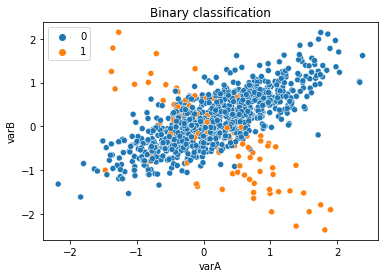

In [10]:
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:

# phân loại nhị phân ==> 2 lớp

X, y = make_data(
    n_classes=2, # phân loại nhị phân
    weights=[0.90], # không cân bằng, 10:1
    sep=0.2, # khả năng phân tách lớp
)

# in ra mục tiêu không cân bằng
print('Target imbalance: ')
print(y.value_counts())

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Binary classification')
plt.show()

<details><summary> Gợi ý </summary>

Đặt ```n_classes=2```

</details>

Lớp thiểu số màu vàng, lớp đa số màu xanh dương. Có một số lớp chồng chéo ở đây.

## Huấn luyện Random Forest

Chúng ta sẽ dùng Random Forest để xác định instance hardness, thực hiện với kiểm định chéo, hãy cố gắng thực hiện quy trình càng sát với triển khai của imbalanced-learn càng tốt.

Thông tin chi tiết về các hàm sklearn mà chúng ta sử dụng:

- [StratifiedKFold](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html)
- [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [11]:
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:

# thiết lập cơ chế kiểm định chéo phân tầng

skf = StratifiedKFold(
    n_splits=3, # kiểm định chéo 3-fold
    shuffle=True,
    random_state=1,
)

skf

StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

<details><summary> Gợi ý </summary>

[StratifiedKFold()](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html)

</details>

In [12]:
# thiết lập random forest

rf = RandomForestClassifier(n_estimators=5, random_state=1, max_depth=1)

## Tính toán giá trị instance hardness

In [13]:
# lấy các dự đoán từ Random Forest
# với kiểm định chéo

## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:

probs = cross_val_predict(
    rf,
    X,
    y,
    cv=skf,
    n_jobs=-1,
    method="predict_proba",
)

probs = pd.DataFrame(probs, columns=['p(0)', 'p(1)'])

probs

,p(0),p(1)
0,0.889566,0.110434
1,0.903987,0.096013
2,0.896250,0.103750
3,0.896250,0.103750
4,0.903987,0.096013
...,...,...
995,0.889566,0.110434
996,0.889566,0.110434
997,0.848812,0.151188
998,0.889566,0.110434


<details><summary> Gợi ý </summary>

[cross_val_predict()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

</details>

Lớp 0 là lớp đa số, nên chúng ta cần undersample lớp đó. Chúng ta có thể thực hiện bằng cách loại các quan sát có p(0) thấp, tương đương với instance hardness cao. Nhớ rằng instance hardness bằng 1 trừ đi xác suất của lớp.

## Under-sample các quan sát của lớp đa số 

### Ngưỡng bất kỳ

In [14]:
# để chọn ngưỡng, hãy kiểm tra xác suất
# phân phối

probs.describe()

,p(0),p(1)
count,1000.000000,1000.000000
mean,0.889839,0.110161
std,0.052598,0.052598
min,0.252222,0.060097
25%,0.889566,0.096013
50%,0.896250,0.103750
75%,0.903987,0.110434
max,0.939903,0.747778


Chúng ta thấy phần lớn quan sát của lớp đa số có p(0) > 0.88. Hãy thử loại các quan sát dưới 0.85. Tất nhiên chúng ta cần thử vài ngưỡng và xem ngưỡng nào hoạt động tốt nhất với tập dữ liệu.

In [15]:
# 2 cách diễn đạt tương đương:

# loại các quan sát khỏi lớp đa số có instance hardness ( 1 - p(0) ) là cao 
# loại các quan sát khỏi lớp đa số có p(0) là thấp

# chúng ta loại các quan sát khỏi lớp đa số (chỉ) khi  
# random forest trả về xác suất dưới 0.85

condition = (y==0) & (probs['p(0)'] <= 0.85)

# tìm các quan sát đó trong tập dữ liệu
## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
filtered = X.loc[condition]

# số quan sát để loại
filtered.shape

(27, 2)

<details><summary> Gợi ý </summary>

Use ```condition```

</details>

Không có nhiều quan sát bị loại vì mô hình phân loại các lớp khá tốt.

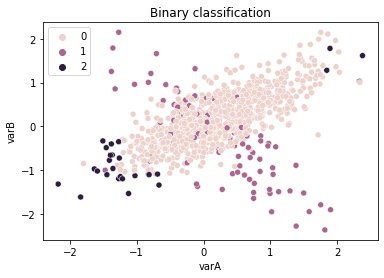

In [16]:
# hãy xác định những quan sát nào sẽ bị loại

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 2* condition
)

plt.title('Binary classification')
plt.show()

Màu hồng nhạt là các quan sát của lớp đa số, hồng đậm là các quan sát của lớp thiểu số và màu tím là các quan sát sẽ bị loại khỏi lớp đa số vì chúng khó phân loại nhất.

In [ ]:
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:

# giảm các trường hợp khó

X_resampled = X....(filtered.index)
y_resampled = y....(filtered.index)

X_resampled.shape, y_resampled.shape

((973, 2), (973,))

<details><summary> Gợi ý </summary>

[drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)

</details>

In [ ]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:

# print the target imabalance after filtering

print('Resampled Target imbalance: ')
print(y_resampled....())

Resampled Target imbalance: 
0    867
1    106
dtype: int64


<details><summary> Gợi ý </summary>

Sử dụng ```value_counts```

</details>

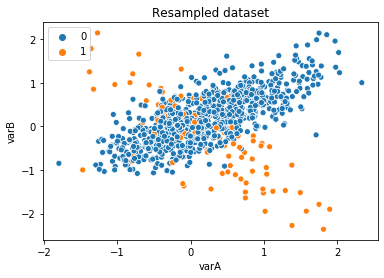

In [ ]:
# vẽ biểu đồ dữ liệu đã lấy lại mẫu

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()

**BÀI TẬP**

- Sử dụng thuật toán khác thay vì Random Forest và xem nó tác động thế nào tới các mẫu sẽ bị lọc ra.
- Thử với ngưỡng lọc và đánh giá tác động của việc lọc.

 Bước tiếp theo sẽ huấn luyện mô hình trên tập dữ liệu đã lọc và xác định xem mô hình có cho chất lượng tốt hơn không. Chúng ta sẽ thực hiện điều đó sáu với tập dữ liệu thực.

### Under-sample dữ liệu để khớp với tỷ lệ cân bằng

Ở phần sau, chúng ta sẽ tìm một ngưỡng gúp cân bằng tỳ lệ cân bằng thay vì ngưỡng bất kỳ.

In [ ]:
# mục tiêu không cân bằng

balance = y.value_counts()

balance

0    894
1    106
dtype: int64

In [ ]:
# tỷ lệ cân bằng

balance[0] / balance[1]

8.433962264150944

In [ ]:
# chúng ta có thể lựa chọn tùy ý từ lớp đa số
# 106 quan sát hàng đầu như sau:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
probs[y==0]....(by='p(0)', ascending=False).head(106)

,p(0),p(1)
655,0.939903,0.060097
768,0.939903,0.060097
404,0.939903,0.060097
279,0.939903,0.060097
857,0.939903,0.060097
...,...,...
553,0.903987,0.096013
336,0.903987,0.096013
369,0.903987,0.096013
521,0.903987,0.096013


<details><summary> Gợi ý </summary>

[sort_values()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)

</details>

Nhưng như chúng ta thấy trên biểu đồ, nhiều quan sát có giá trị xác suất tương tự, vậy tại sao chúng ta lại giữ và loại các quan sát khác?

Để tránh tình trạng này, imbalanced-learn xác định ngưỡng theo sự không cân bằng (imbalance) rồi lựa chọn toàn bộ quan sát trên ngưỡng đó. Điều này như sau:

In [ ]:
# số mẫu cần thiết 
n_samples = 106

# tổng số quan sát của lớp đa số
majority_samples = 894

## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:

# chúng ta tìm thấy bao nhiêu phần trăm 
# số quan sát này

perc = n_samples / ...

perc

0.1185682326621924

<details><summary> Gợi ý </summary>

Sử dụng ```majority_samples```

</details>

In [ ]:
# chúng ta cần các quan sát có p(0) cao nhất
# nên chúng ta xem xét 11% đầu tiên chứ không phải 11% ở cuối

# do đó chúng ta cần tìm phần trăm hàng đầu là 1 - perc

perc = (1 - perc) * 100

perc

88.14317673378076

In [ ]:
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:

# tìm ngưỡng mà chúng ta tìm thấy 88% các quan sát

threshold = np.percentile(probs[y == 0]['p(0)'], ...)

threshold

0.9039872125121304

<details><summary> Gợi ý </summary>

Sử dụng ```perc```

</details>

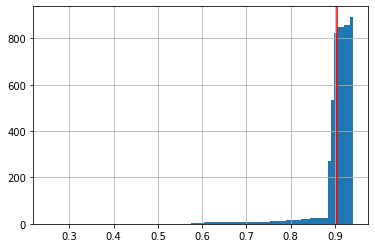

In [ ]:
# khiến nó trực quan hơn một chút

probs[y == 0]['p(0)'].hist(cumulative=True, bins=100)
plt.axvline(x=threshold, color='red')

In [ ]:
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:

# chúng ta loại các quan sát khỏi lớp đa số (chỉ) khi 
# random forest trả về xác suất dưới ngưỡng

condition = (y==0) & (probs['p(0)'] < ...)

# tìm các quan sát đó trong tập dữ liệu
filtered = X.loc[...]

# số quan sát để loại
filtered.shape

(534, 2)

<details><summary> Gợi ý </summary>

Sử dụng ```threshold```

</details>

Chúng ta sẽ loại khá nhiều quan sát để đạt được tỷ lệ cân bằng.

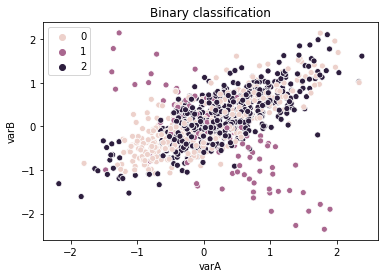

In [ ]:
# hãy xác định những quan sát nào sẽ bị loại

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 2* condition
)

plt.title('Binary classification')
plt.show()

In [ ]:
# giảm các trường hợp khó

X_resampled = X.drop(filtered.index)
y_resampled = y.drop(filtered.index)

X_resampled.shape, y_resampled.shape

((466, 2), (466,))

In [ ]:
# in ra mục tiêu không cân bằng sau khi lọc

print('Resampled Target imbalance: ')
print(y_resampled.value_counts())

Resampled Target imbalance: 
0    360
1    106
dtype: int64


Như các bạn thấy, chúng ta đã giảm số quan sát của lớp đa số, nhưng không đạt được cân bằng mong muốn vì nhiều quan sát không có giá trị xác suất tương tự. Cho nên thuật toán giữ lại toàn bộ.

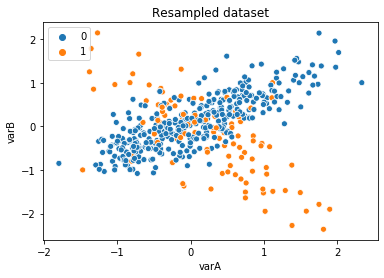

In [ ]:
# cuối cùng, vẽ biểu đồ dữ liệu đã lấy lại mẫu

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()

### Instance hardness với imbalanced-learn

Hãy lặp lại bài tập nhưng bây giờ sử dụng imbalanced-learn

[InstanceHardnessThreshold](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html)

In [ ]:
## Yêu cầu 10:
## VIẾT CODE Ở ĐÂY:

# thiết lập ngưỡng instance hardness

iht = ...(
    estimator=rf,
    sampling_strategy='auto',  # chỉ undersample lớp đa số
    random_state=1,
    n_jobs=4, # máy có 4 bộ xử lý
    cv=3,  # kiểm định chéo 3-fold
)

X_resampled, y_resampled = iht....(X, y)

<details><summary> Gợi ý </summary>

[InstanceHardnessThreshold()](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html)

</details>

In [ ]:
# dữ liệu ban đầu

X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# dữ liệu undersampled

X_resampled.shape, y_resampled.shape

((283, 2), (283,))

In [ ]:
# tỷ lệ cân bằng sau khi lấy lại mẫu

y_resampled.value_counts()

0    177
1    106
dtype: int64

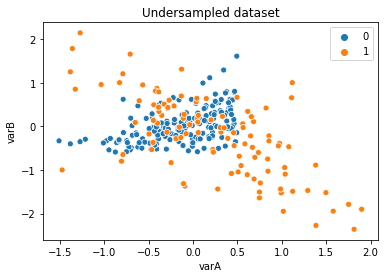

In [ ]:
# plot undersampled data

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()

In [ ]:
# hãy tìm các quan sát đã bị loại

removed_obs = [0 if x in iht.sample_indices_ else 1 for x in X.index ]

len(removed_obs), np.sum(removed_obs)

(1000, 717)

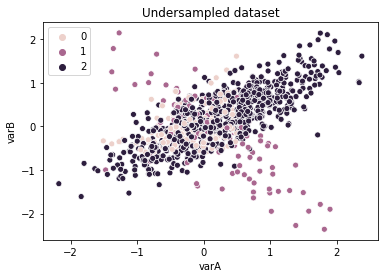

In [ ]:
# vẽ biểu đồ dữ liệu ban đầu làm nổi bật các quan sát đã loại

sns.scatterplot(
        data=X, x="varA", y="varB", hue= y + 2* pd.Series(removed_obs)
    )

plt.title('Undersampled dataset')
plt.show()

## Ngưỡng Instance Hardness 

### Dữ liệu thực - So sánh chất lượng

Nó có hoạt động tốt với các tập dữ liệu thực không? 

Điều này còn tùy thuộc vào tập dữ liệu, do đó hãy thử và so sánh mô hình đã xây trên toàn bộ tập dữ liệu với mô hình được xây trên tập dữ liệu undersampled.

In [ ]:
# load dữ liệu
# chỉ một vài quan sát để tăng tốc tính toán

data = pd.read_csv('../kdd2004.csv').sample(10000, random_state=1)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,target
88984,71.15,32.43,1.29,28.0,-39.0,1639.2,-1.33,1.03,9.5,-82.5,...,1054.2,0.80,3.28,0.0,-60.0,623.1,0.11,0.25,0.31,-1
140218,30.72,36.17,-0.24,-6.5,3.5,1249.7,0.45,0.32,8.0,-75.0,...,1524.8,-2.70,0.75,-3.0,-20.0,1.2,0.74,0.56,0.29,-1
91280,11.84,42.86,0.21,-25.0,26.5,2346.3,0.10,-0.77,-38.0,-62.0,...,3392.7,-2.76,1.02,21.0,-106.0,1236.6,0.01,0.56,0.27,-1
22351,26.67,28.57,-0.57,0.5,50.5,1195.0,0.69,0.16,-3.5,-43.0,...,1301.9,1.10,0.09,7.0,-29.0,263.0,0.51,0.58,0.61,-1
27966,40.32,26.34,-0.97,-57.5,79.5,4939.5,-0.80,0.56,7.5,-117.5,...,3544.6,0.84,0.02,15.0,-196.0,1667.2,0.16,0.14,0.28,-1


In [ ]:
# mục tiêu không cân bằng

data.target.value_counts() / len(data)

-1    0.99
 1    0.01
Name: target, dtype: float64

In [ ]:
## Yêu cầu 11:
## VIẾT CODE Ở ĐÂY:

# tách thành tập huấn luyện và tập kiểm tra

X_train, X_test, y_train, y_test = ..._test_split(
    data.drop(labels=['target'], axis=1),  # giảm mục tiêu
    data['target'],  # chỉ mục tiêu
    test_size=0.3,
    random_state=0,
)

In [ ]:
# thiết lập mô hình chúng ta muốn so sánh
# nhớ rằng chúng ta nên tính instance hardness
# với cùng mô hình mà chúng ta định huấn luyện làm mô hình cuối cùng

logit = LogisticRegression(random_state=0, max_iter=1000)

rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=2)

In [ ]:
## Yêu cầu 12:
## VIẾT CODE Ở ĐÂY:

# lấy lại mẫu sử dụng
# ngưỡng instance hardness với hồi quy logistic 

iht_logit = ...(
    estimator=logit,
    sampling_strategy='auto',  # chỉ undersample lớp đa số
    random_state=0,
    n_jobs=4, # máy có 4 bộ xử lý
    cv=3)  # kiểm định chéo 3-fold

X_logit, y_logit = iht_logit....(X_train, ...)

In [ ]:
## Yêu cầu 13:
## VIẾT CODE Ở ĐÂY:

# lấy lại mẫu sử dụng
# ngưỡng instance hardness với random forest

iht_rf = ...(
    estimator=rf,
    sampling_strategy='auto',  # chỉ undersample lớp đa số
    random_state=0,
    n_jobs=4, # máy có 4 bộ xử lý
    cv=3)  # kiểm định chéo 3-fold


X_rf, y_rf = iht_rf....(..., y_train)

In [ ]:
# so sánh hình dạng của tập dữ liệu ban đầu và tập dữ liệu đã lấy lại mẫu

X_train.shape, X_logit.shape, X_rf.shape

((7000, 74), (138, 74), (138, 74))

## So sánh chất lượng thuật toán học máy

Hãy so sánh chất lượng mô hình khi có và không có kỹ thuật undersampling.

In [ ]:
# hàm huấn luyện random forest và đánh giá chất lượng

def run_randomForests(X_train, X_test, y_train, y_test):
    
    model = rf
    model.fit(X_train, y_train)

    print('Train set')
    pred = model.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = model.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [ ]:
# hàm huấn luyện hồi quy logistic và đánh giá chất lượng

def run_logit(X_train, X_test, y_train, y_test):
    
    model = logit
    model.fit(X_train, y_train)

    print('Train set')
    pred = model.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = model.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

### So sánh Random forest

In [ ]:
## Yêu cầu 14:
## VIẾT CODE Ở ĐÂY:

# đánh giá chất lượng thuật toán đã xây
# sử dụng tập dữ liệu ban đầu, không cân bằng

..._randomForests(X_train,
                  ...,
                  ...,
                  y_test)

Train set
Random Forests roc-auc: 0.964028446028032
Test set
Random Forests roc-auc: 0.9516509305837743


In [ ]:
## Yêu cầu 15:
## VIẾT CODE Ở ĐÂY:

# đánh giá chất lượng của cùng một thuật toán nhưng giờ được huấn luyện
# sử dụng dữ liệu đã lấy lại mẫu với iht với random forest

..._randomForests(...,
                  X_test,
                  y_rf,
                  ...)

Train set
Random Forests roc-auc: 0.9796261289645033
Test set
Random Forests roc-auc: 0.9941872467106335


Lọc ra các trường hợp khó của tập dữ liệu, cải thiện chất lượng của Random Forest trên tập kiểm tra (nhớ rằng tập kiểm tra không được lấy lại mẫu nên nó là tập dữ liệu tốt để so sánh chất lượng mô hình).

### So sánh hồi quy Logistic

In [ ]:
## Yêu cầu 16:
## VIẾT CODE Ở ĐÂY:

# đánh giá chất lượng thuật toán đã xây
# sử dụng tập dữ liệu ban đầu, không cân bằng

..._logit(...,
          X_test,
          y_train,
          ...)

Train set
Logistic Regression roc-auc: 0.9974866123423645
Test set
Logistic Regression roc-auc: 0.9925031780006303


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:

# đánh giá chất lượng của cùng một thuật toán nhưng giờ được huấn luyện
# sử dụng dữ liệu đã lấy lại mẫu với iht với hồi quy logistic

..._logit(X_logit,
          ...,
          ...,
          y_test)

Train set
Logistic Regression roc-auc: 0.9714345725687882
Test set
Logistic Regression roc-auc: 0.9038125142602592


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**BÀI TẬP**

- Kiểm tra xem những quan sát nào bị loại sử dụng IHT và hồi quy logistic để tìm hiểu tại sao chất lượng không được cải thiện.
- thay đổi chiến lược undersampling trong IHT từ imbalanced-learn và so sánh kết quả.

# Ngưỡng Instance Hardness

Instance hardness là xác suất để một quan sát bị phân loại sai. Hay nói cách khác, instance hardness bằng 1 trừ đi xác suất của lớp. Cho lớp 1:

- **instance hardness = 1 - p(1)**

Instance hardness phụ thuộc vào thuật toán được dùng trong phân loại và phân tách lớp.

## Instance Hardness Filtering

Instance Hardness filtering xác định instance hardness và loại bỏ các quan sát khó phân loại. Nói cách khác, là loại các quan sát có **instance hardness** cao hoặc **xác suất lớp** thấp. Câu hỏi đặt ra là làm thế nào để xác định ngưỡng đó.

Trong notebook này, chúng ta sẽ:

- Xác định instance hardness của các quan sát
- Lọc các quan sát của lớp đa số theo một ngưỡng tùy ý
- Lọc các quan sát của lớp đa số theo đề xuất của Imbalanced-learn
- Sử dụng imbalance-learn để triển khai Instance Hardness

Trong notebook này, chúng ta sẽ sử dụng ví dụ về phân loại nhị phân. **Với phân loại đa lớp, hãy xem notebook sau**.

## Tạo và vẽ biểu đồ tập dữ liệu đa lớp

Target imbalance: 
0    496
1    399
2    105
dtype: int64


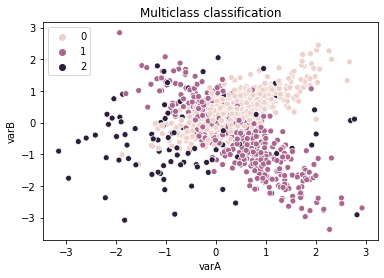

In [ ]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:

# phân loại đa lớp ==> 3 lớp

X, y = make_...(
    n_classes=..., # đa lớp 
    weights=[0.5, 0.4, 0.1], # không cân bằng
    sep=0.5, # khả năng phân tách lớp
)

# in ra mục tiêu không cân bằng
print('Target imbalance: ')
print(y.value_counts())

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue=y
)

plt.title('Multiclass classification')
plt.show()

<details><summary> Gợi ý </summary>

```n_classes=3```

</details>

Lớp thiểu số màu hồng đậm, lớp đa số màu hồng nhạt. Có một số lớp chồng chéo ở đây.

## Huấn luyện Random Forest

Chúng ta sẽ dùng Random Forest để xác định instance hardness, thực hiện với kiểm định chéo, hãy cố gắng thực hiện quy trình càng sát với triển khai của imbalanced-learn càng tốt. Để xác định instance hardness, chúng ta sẽ thực hiện theo cách One vs Rest, vậy hãy kết hợp thuật toán với OneVsRestClassifier.

Thông tin chi tiết về các hàm sklearn mà chúng ta sử dụng:

- [StratifiedKFold](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html)
- [cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)
- [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [ ]:
## Yêu cầu 17:
## VIẾT CODE Ở ĐÂY:

# thiết lập cơ chế kiểm định chéo phân tầng

skf = ...(
    n_splits=3, # kiểm định chéo 3-fold
    shuffle=True,
    random_state=1,
)

skf

StratifiedKFold(n_splits=3, random_state=1, shuffle=True)

<details><summary> Gợi ý </summary>

[StratifiedKFold()](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.StratifiedKFold.html)

</details>

In [ ]:
## Yêu cầu 18:
## VIẾT CODE Ở ĐÂY:

# thiết lập random forest
# theo cách 1 vs rest

rf = ...(
    RandomForestClassifier(n_estimators=10, random_state=1, max_depth=2),
    n_jobs=4,
)

<details><summary> Gợi ý </summary>

[OneVsRestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

</details>

## Tính toán giá trị instance hardness

In [ ]:
## Yêu cầu 19:
## VIẾT CODE Ở ĐÂY:

# lấy các dự đoán từ Random Forest
# với kiểm định chéo

probs = ...(
    rf,
    X,
    y,
    cv=skf,
    n_jobs=4,
    method="predict_proba",
)

probs = pd.DataFrame(probs, columns=['p(0)', 'p(1)', 'p(2)'])

# xác suất là 1 vs Rest
probs

,p(0),p(1),p(2)
0,0.690328,0.256658,0.053014
1,0.241402,0.328094,0.430504
2,0.429384,0.497497,0.073119
3,0.663519,0.273183,0.063298
4,0.202036,0.453133,0.344831
...,...,...,...
995,0.656766,0.270403,0.072832
996,0.666431,0.280055,0.053514
997,0.642936,0.292809,0.064254
998,0.312638,0.569629,0.117733


<details><summary> Gợi ý </summary>

[cross_val_predict()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

</details>

Lớp 0 và 1 là lớp đa số, nên chúng ta cần undersample chúng. Chúng ta có thể thực hiện bằng cách loại các quan sát có p(0) và p(1) thấp, tương đương với instance hardness cao. Nhớ rằng instance hardness bằng 1 trừ đi xác suất của lớp.

## Under-sample các quan sát của lớp đa số

### Ngưỡng bất kỳ

In [ ]:
# để chọn ngưỡng, hãy kiểm tra xác suất
# phân phối

probs.describe()

,p(0),p(1),p(2)
count,1000.000000,1000.000000,1000.000000
mean,0.491178,0.403093,0.105729
std,0.205294,0.167309,0.099443
min,0.060039,0.148687,0.041796
25%,0.276382,0.269223,0.055158
50%,0.605652,0.318781,0.066503
75%,0.675442,0.551213,0.105131
max,0.730871,0.782360,0.655570


Chúng ta thấy phần lớn quan sát của lớp đa số có p(0) > ~0.30.88. Hãy thử loại các quan sát dưới giá trị này. Tất nhiên chúng ta cần thử vài ngưỡng và xem ngưỡng nào hoạt động tốt nhất với tập dữ liệu.

In [ ]:
# 2 cách diễn đạt tương đương:

# loại các quan sát khỏi lớp đa số có instance hardness ( 1 - p(0) ) cao
# loại các quan sát khỏi lớp đa số có p(0) là thấp

# chúng ta loại các quan sát khỏi lớp đa số (chỉ) khi 
# random forest trả về xác suất dưới 0.35

condition_0 = (y==0) & (probs['p(0)'] <= 0.30)
condition_1 = (y==1) & (probs['p(1)'] <= 0.30)

## Yêu cầu 20:
## VIẾT CODE Ở ĐÂY:

# tìm các quan sát đó trong tập dữ liệu
filtered_0 = X.loc[..._0]
filtered_1 = X.loc[..._1]

# số quan sát để loại
filtered_0.shape, filtered_1.shape

((18, 2), (69, 2))

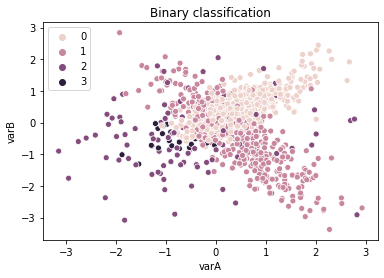

In [ ]:
# hãy xác định những quan sát nào sẽ bị loại
# trước tiên từ lớp 0

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_0
)

plt.title('Binary classification')
plt.show()

Màu đậm nhất (nhãn 3) sẽ bị loại, chúng ở biên của lớp 2, lớp thiểu số.

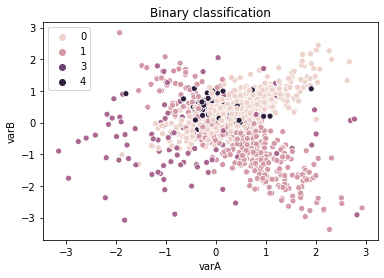

In [ ]:
# hãy xác định những quan sát nào sẽ bị loại
# từ lớp 1

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_1
)

plt.title('Binary classification')
plt.show()

Màu đậm nhất (nhãn 3) sẽ bị loại, chúng ở biên của lớp 0, lớp đa số.

In [ ]:
# giảm các trường hợp khó từ cả hai lớp đa số

# loại lớp 0 - trường hợp khó
X_resampled = X.drop(filtered_0.index)
y_resampled = y.drop(filtered_0.index)

# loại lớp 1 - trường hợp khó
X_resampled = X_resampled.drop(filtered_1.index)
y_resampled = y_resampled.drop(filtered_1.index)

X_resampled.shape, y_resampled.shape

((913, 2), (913,))

In [ ]:
# in ra mục tiêu không cân bằng sau khi lọc

print('Resampled Target imbalance: ')
print(y_resampled.value_counts())

Resampled Target imbalance: 
0    478
1    330
2    105
dtype: int64


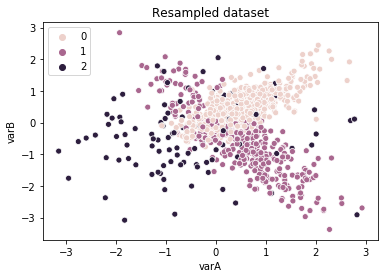

In [ ]:
# vẽ biểu đồ dữ liệu đã lấy lại mẫu

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()

**BÀI TẬP**

- Sử dụng thuật toán khác thay vì Random Forest và xem nó tác động thế nào tới các mẫu sẽ bị lọc ra.
- Thử với ngưỡng lọc và đánh giá tác động của việc lọc.




### Under-sample dữ liệu để khớp với tỷ lệ cân bằng

Ở phần sau, chúng ta sẽ tìm một ngưỡng gúp cân bằng tỳ lệ cân bằng thay vì ngưỡng bất kỳ

Chúng ta cần thực hiện quá trình này với các lớp đa số.

In [ ]:
# mục tiêu không cân bằng

balance = y.value_counts()

balance

0    496
1    399
2    105
dtype: int64

In [ ]:
class_ = 0

# số mẫu cần thiết 
n_samples = balance[2]

# tổng số quan sát của lớp đa số
majority_samples = balance[class_]

## Yêu cầu 21:
## VIẾT CODE Ở ĐÂY:

# chúng ta tìm thấy bao nhiêu phần trăm 
# số quan sát này
perc = n_samples / ...

perc

0.21169354838709678

<details><summary> Gợi ý </summary>

Sử dụng ```majority_samples```

</details>

In [ ]:
# chúng ta cần các quan sát có p(0) cao nhất
# nên chúng ta sẽ xem xét các phần trăm hàng đầu

perc = (1 - perc) * 100

perc

78.83064516129032

In [ ]:
## Yêu cầu 22:
## VIẾT CODE Ở ĐÂY:

# tìm ngưỡng mà chúng ta thấy 78% quan sát

threshold_0 = np.percentile(probs[y == ...]['p(0)'], perc)

threshold_0

0.693734670570368

<details><summary> Gợi ý </summary>

Sử dụng ```class_```

</details>

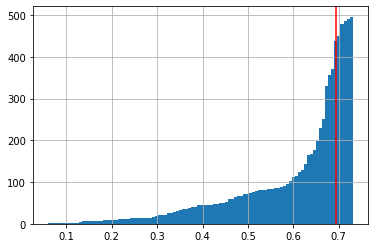

In [ ]:
## Yêu cầu 23:
## VIẾT CODE Ở ĐÂY:

# khiến nó trực quan hơn một chút

probs[y == ...]['p(0)'].hist(cumulative=True, bins=100)
plt.axvline(x=threshold_0, color='red')

<details><summary> Gợi ý </summary>

Sử dụng ```class_```

</details>

In [ ]:
## Yêu cầu 24:
## VIẾT CODE Ở ĐÂY:

# chúng ta loại các quan sát khỏi lớp đa số (chỉ) khi 
# random forest trả về xác suất dưới ngưỡng

condition_0 = (y==class_) & (probs['p(0)'] < ...)

# tìm các quan sát đó trong tập dữ liệu
filtered_0 = X.loc[condition_0]

# số quan sát để loại
filtered_0.shape

(385, 2)

<details><summary> Gợi ý </summary>

Sử dụng ```threshold_0```

</details>

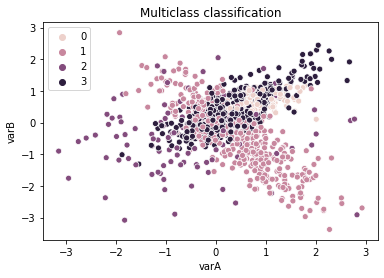

In [ ]:
# hãy xác định những quan sát nào sẽ bị loại

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_0
)

plt.title('Multiclass classification')
plt.show()

In [ ]:
# giờ hãy lặp lại quy trình cho lớp 1

class_ = 1

# số mẫu cần thiết 
n_samples = balance[2]

# tổng số quan sát của lớp đa số
majority_samples = balance[class_]

# chúng ta tìm thấy bao nhiêu phần trăm 
# số quan sát này
perc = n_samples / majority_samples

perc = (1 - perc) * 100

# tìm ngưỡng mà chúng ta thấy các % quan sát hàng đầu

threshold_1 = np.percentile(probs[y == class_]['p(1)'], perc)

threshold_1

0.6581840116263563

In [ ]:
## Yêu cầu 25:
## VIẾT CODE Ở ĐÂY:

# chúng ta loại các quan sát khỏi lớp đa số (chỉ) khi 
# random forest trả về xác suất dưới ngưỡng

condition_1 = (y==class_) & (probs['p(1)'] < ...)

# tìm các quan sát đó trong tập dữ liệu
filtered_1 = X.loc[condition_1]

# số quan sát để loại
filtered_1.shape

(291, 2)

<details><summary> Gợi ý </summary>

Sử dụng ```threshold_1```

</details>

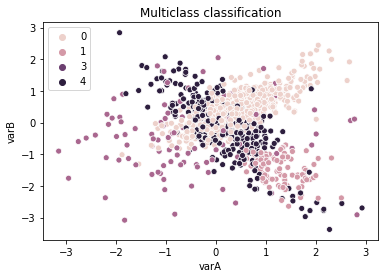

In [ ]:
# hãy xác định những quan sát nào sẽ bị loại

# vẽ biểu đồ dữ liệu
sns.scatterplot(
    data=X, x="varA", y="varB", hue= y + 3* condition_1
)

plt.title('Multiclass classification')
plt.show()

In [ ]:
# giảm các trường hợp khó

X_resampled = X.drop(filtered_0.index)
y_resampled = y.drop(filtered_0.index)

X_resampled = X_resampled.drop(filtered_1.index)
y_resampled = y_resampled.drop(filtered_1.index)

X_resampled.shape, y_resampled.shape

((324, 2), (324,))

In [ ]:
# in ra mục tiêu không cân bằng after filtering

print('Resampled Target imbalance: ')
print(y_resampled.value_counts())

Resampled Target imbalance: 
0    111
1    108
2    105
dtype: int64


Như các bạn thấy, chúng ta đã giảm số lượng quan sát của lớp đa số, nhưng không đạt được cân bằng mong muốn vì nhiều quan sát không có giá trị xác suất tương tự. Cho nên thuật toán giữ lại toàn bộ.

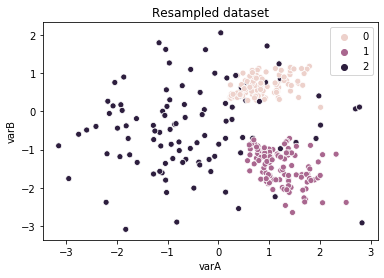

In [ ]:
# cuối cùng, vẽ biểu đồ dữ liệu đã lấy lại mẫu

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Resampled dataset')
plt.show()

### Instance hardness với imbalanced-learn

Hãy lặp lại bài tập nhưng bây giờ sử dụng imbalanced-learn

[InstanceHardnessThreshold](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html)

In [ ]:
## Yêu cầu 26:
## VIẾT CODE Ở ĐÂY:

# thiết lập ngưỡng instance hardness

iht = ...(
    estimator=rf,
    sampling_strategy='auto',  # undersample tất cả các lớp đa số
    random_state=1,
    n_jobs=4, # máy có 4 bộ xử lý
    cv=3,  # kiểm định chéo 3-fold
)

X_resampled, y_resampled = iht....(..., y)

<details><summary> Gợi ý </summary>

[InstanceHardnessThreshold()](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.InstanceHardnessThreshold.html)

</details>

In [ ]:
# dữ liệu ban đầu

X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# dữ liệu undersampled

X_resampled.shape, y_resampled.shape

((323, 2), (323,))

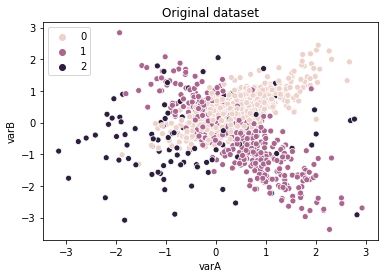

In [ ]:
# vẽ biểu đồ dữ liệu ban đầu

sns.scatterplot(
        data=X, x="varA", y="varB", hue=y
    )

plt.title('Original dataset') 
plt.show()

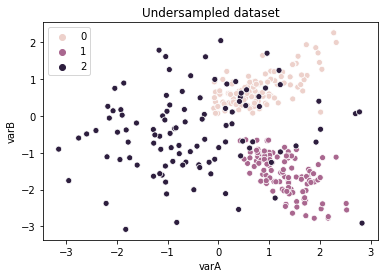

In [ ]:
# vẽ biểu đồ dữ liệu undersampled

sns.scatterplot(
        data=X_resampled, x="varA", y="varB", hue=y_resampled
    )

plt.title('Undersampled dataset') 
plt.show()